BBER Data User's Conference - November 18, 2015 - Karl Benedict (UNM University Libraries, Director of Research Data Services)

# Demonstrating Interaction with the US Census Bureau's Application Programming Interfaces

This demonstration will illustrate some strategies for interacting programmatically with the US Census Bureau's *Application Programming Interface* (API) accessible from http://www.census.gov/developers/. The specific APIs that will be demonstrated include:

* Census Geocoding Services - http://www.census.gov/data/developers/data-sets/Geocoding-services.html
* Decennial Census (2010, 2000, 1990) - http://www.census.gov/data/developers/data-sets/decennial-census-data.html
* Business Dynamics Statistics (1976-2013) - http://www.census.gov/data/developers/data-sets/business-dynamics.html

In order to use many of these APIs you must request and receive an API key from the Census Bureau - http://api.census.gov/data/key_signup.html. For this demonstration I will be using my key, but you must request your own to use these services. 

While the examples demonstrated here use the Python programming language, interaction with the Census APIs can be automated using any modern programming language that supports interaction with remote web services (pretty much all of them). 

## Preliminary settings and loading of general programming libraries

In [1]:
%matplotlib inline

import requests # for interacting with remote web services published over HTTP

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

myKey = '001204b7403884e245c12c35bdcc955c68ca6dda' # replace this with your own

## Census Geocoding Services

*Census Geocoding Services* allow for the submission of a street address for which an approximate Latitude-Longitude coordinate will be calculated and used to return the corresponding Census geography for that location. 

The *Census Geocoding Services* API documentation PDF is found here - http://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.pdf

*Let's now build an address and obtain the Census geographies that correspond with that address*

In [2]:
# Build the request
requestBase = "http://geocoding.geo.census.gov/geocoder/geographies/address"
params = {
    'street':'5600 Eagle Rock Ave',
    'city':'Albuquerque',
    'state':'NM',
    'zip':'87113',
    'benchmark':'Public_AR_Census2010', # Public Address Ranges - Census 2010 Benchmark
    'format':'json',
    'layers':'all',
    'vintage':'Census2010_Census2010' # Census 2010 Vintage - Census 2010 Benchmark
    }

# Some other addresses to try ...

# The Palace of the Governors in Santa Fe: 105 W Palace Ave, Santa Fe, NM 87501
params2 = {
    'street':'105 W Palace Ave',
    'city':'Santa Fe',
    'state':'NM',
    'zip':'87501',
    'benchmark':'Public_AR_Census2010',
    'format':'json',
    'layers':'all',
    'vintage':'Census2010_Census2010'
    }

# The Transamerica Pyramid in San Francisco, CA: 600 Montgomery St, San Francisco, CA 94111
params3 = {
    'street':'600 Montgomery St',
    'city':'San Francisco',
    'state':'CA',
    'zip':'94111',
    'benchmark':'Public_AR_Census2010',
    'format':'json',
    'layers':'all',
    'vintage':'Census2010_Census2010'
    }



# Submit the request to the US Census service
response = requests.get(requestBase,params3)
print(response.url)
print('')
print("The glossary for the attribute names for the output from the request can be found here - http://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_attribute_glossary.html")
response.json()


https://geocoding.geo.census.gov/geocoder/geographies/address?street=600+Montgomery+St&city=San+Francisco&state=CA&zip=94111&benchmark=Public_AR_Census2010&format=json&layers=all&vintage=Census2010_Census2010

The glossary for the attribute names for the output from the request can be found here - http://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_attribute_glossary.html


{'result': {'input': {'benchmark': {'id': '9',
    'benchmarkName': 'Public_AR_Census2010',
    'benchmarkDescription': 'Public Address Ranges - Census 2010 Benchmark',
    'isDefault': False},
   'vintage': {'id': '910',
    'vintageName': 'Census2010_Census2010',
    'vintageDescription': 'Census2010 Vintage - Census2010 Benchmark',
    'isDefault': True},
   'address': {'street': '600 Montgomery St',
    'city': 'San Francisco',
    'state': 'CA',
    'zip': '94111'}},
  'addressMatches': [{'matchedAddress': '600 Montgomery St, SAN FRANCISCO, CA, 94111',
    'coordinates': {'x': -122.40312, 'y': 37.79469},
    'tigerLine': {'tigerLineId': '192281262', 'side': 'R'},
    'addressComponents': {'fromAddress': '600',
     'toAddress': '648',
     'preQualifier': '',
     'preDirection': '',
     'preType': '',
     'streetName': 'Montgomery',
     'suffixType': 'St',
     'suffixDirection': '',
     'suffixQualifier': '',
     'city': 'SAN FRANCISCO',
     'state': 'CA',
     'zip': '941

In [4]:
myFIPS = []

for item in response.json()['result']['addressMatches']:
    for geography in item['geographies']['Census Blocks']:
        block = geography['BLOCK']
        blockGroup = geography['BLKGRP']
        tract = geography['TRACT']
        county = geography['COUNTY']
        state = geography['STATE']
        FIPScode = state+county+tract+blockGroup
        print('Block: '+block)
        print('Block Group: '+blockGroup)
        print('Tract: '+tract)
        print('County: '+county)
        print('State: '+state)
        print('FIPS Code: '+FIPScode)
        myFIPS.append({'FIPScode':FIPScode,'state':state,'county':county,'tract':tract,'blockGroup':blockGroup,'block':block})
        print(myFIPS)

Block: 1013
Block Group: 1
Tract: 061100
County: 075
State: 06
FIPS Code: 060750611001
[{'FIPScode': '060750611001', 'state': '06', 'county': '075', 'tract': '061100', 'blockGroup': '1', 'block': '1013'}]


## Decennial Census (2010, 2000, 1990)

Now let's get some demographic data for the identified geographies

In [5]:
#2010 Decennial Census
requestBase = "http://api.census.gov/data/2010/sf1"
params = {
    'key':myKey,
    'get':'H0030002,H0030003,H0040002,H0040003,H0040004', # Occupied,Vacant,Owned-with mortgage, Owned-free and clear, renter
    'for':'county:'+county,
    'in':'state:'+state
    }

# Submit the request to the US Census service
response = requests.get(requestBase,params)
print(response.url)

print
print('The variable names are defined here - http://api.census.gov/data/2010/sf1/variables.html')
print
print(response.json())
print

d2010occupied = float(response.json()[1][0])
d2010vacant = float(response.json()[1][1])
d2010ownerOccupied = float(response.json()[1][2])+float(response.json()[1][3])
d2010renterOccupied = float(response.json()[1][4])

print("2010 Occupied: "+str(d2010occupied))
print("2010 Vacant: "+str(d2010vacant))
d2010occupancyRatio = d2010occupied/(d2010vacant+d2010occupied)
d2010ownerOccupancyRatio = d2010ownerOccupied/(d2010renterOccupied+d2010ownerOccupied)
print("2010 Occupancy ratio: "+str(d2010occupancyRatio))
print("2010 Owner Occupancy ratio: "+str(d2010ownerOccupancyRatio))

dResults = np.array([int('2010'),d2010occupied,d2010vacant,d2010occupancyRatio,d2010ownerOccupancyRatio])
print
print(dResults)

https://api.census.gov/data/2010/sf1?key=001204b7403884e245c12c35bdcc955c68ca6dda&get=H0030002%2CH0030003%2CH0040002%2CH0040003%2CH0040004&for=county%3A075&in=state%3A06
The variable names are defined here - http://api.census.gov/data/2010/sf1/variables.html


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [216]:
#2000 Decennial Census
requestBase = "http://api.census.gov/data/2000/sf1"
params = {
    'key':myKey,
    'get':'H003002,H003003,H004002,H004003', # Occupied,Vacant,Owner occupied,Renter Occupied
    'for':'county:'+county,
    'in':'state:'+state
    }

# Submit the request to the US Census service
response = requests.get(requestBase,params)
print(response.url)
print
print "The variable names are defined here - http://api.census.gov/data/2000/sf1/variables.html"
print('')
print(response.json())
print

d2000occupied = float(response.json()[1][0])
d2000vacant = float(response.json()[1][1])
d2000ownerOccupied = float(response.json()[1][2])
d2000renterOccupied = float(response.json()[1][3])

print "2000 Occupied: "+str(d2000occupied)
print "2000 Vacant: "+str(d2000vacant)
d2000occupancyRatio = d2000occupied/(d2000vacant+d2000occupied)
d2000ownerOccupancyRatio = d2000ownerOccupied/(d2000renterOccupied+d2000ownerOccupied)
print "2000 Occupancy ratio: "+str(d2000occupancyRatio)
print "2000 Owner Occupancy ratio: "+str(d2000ownerOccupancyRatio)

dResults = np.vstack([dResults,[int('2000'),d2000occupied,d2000vacant,d2000occupancyRatio,d2000ownerOccupancyRatio]])
print
print dResults

http://api.census.gov/data/2000/sf1?get=H003002%2CH003003%2CH004002%2CH004003&key=001204b7403884e245c12c35bdcc955c68ca6dda&for=county%3A075&in=state%3A06

The variable names are defined here - http://api.census.gov/data/2000/sf1/variables.html

[[u'H003002', u'H003003', u'H004002', u'H004003', u'state', u'county'], [u'329700', u'16827', u'115391', u'214309', u'06', u'075']]

2000 Occupied: 329700.0
2000 Vacant: 16827.0
2000 Occupancy ratio: 0.951441013254
2000 Owner Occupancy ratio: 0.349987867759

[[  2.01000000e+03   3.45811000e+05   3.11310000e+04   9.17411697e-01
    3.57553693e-01]
 [  2.00000000e+03   3.29700000e+05   1.68270000e+04   9.51441013e-01
    3.49987868e-01]]


In [217]:
#1990 Decennial Census - this isn't working ...
requestBase = "http://api.census.gov/data/1990/sf1"
params = {
    'key':myKey,
    'get':'H0020001,H0020002,H0030001,H0030002', # Occupied,Vacant,Owner occupied,Renter Occupied
    'for':'county:'+county,
    'in':'state:'+state
    }

# Submit the request to the US Census service
response = requests.get(requestBase,params)
print(response.url)
print
print 'The variable names are defined here - http://api.census.gov/data/1990/sf1/variables.html'
print
print(response.json())

d1990occupied = float(response.json()[1][0])
d1990vacant = float(response.json()[1][1])
d1990ownerOccupied = float(response.json()[1][2])
d1990renterOccupied = float(response.json()[1][3])

print "1990 Occupied: "+str(d1990occupied)
print "1990 Vacant: "+str(d1990vacant)
d1990occupancyRatio = d1990occupied/(d1990vacant+d1990occupied)
d1990ownerOccupancyRatio = d1990ownerOccupied/(d1990renterOccupied+d1990ownerOccupied)
print "1990 Occupancy ratio: "+str(d1990occupancyRatio)
print "1990 Owner Occupancy ratio: "+str(d1990ownerOccupancyRatio)

dResults = np.vstack([dResults,[int('1990'),d1990occupied,d1990vacant,d1990occupancyRatio,d1990ownerOccupancyRatio]])
print
print dResults


http://api.census.gov/data/1990/sf1?get=H0020001%2CH0020002%2CH0030001%2CH0030002&key=001204b7403884e245c12c35bdcc955c68ca6dda&for=county%3A075&in=state%3A06

The variable names are defined here - http://api.census.gov/data/1990/sf1/variables.html

[[u'H0020001', u'H0020002', u'H0030001', u'H0030002', u'state', u'county'], [u'305584', u'22887', u'105497', u'200087', u'06', u'075']]
1990 Occupied: 305584.0
1990 Vacant: 22887.0
1990 Occupancy ratio: 0.930322616
1990 Owner Occupancy ratio: 0.345230771245

[[  2.01000000e+03   3.45811000e+05   3.11310000e+04   9.17411697e-01
    3.57553693e-01]
 [  2.00000000e+03   3.29700000e+05   1.68270000e+04   9.51441013e-01
    3.49987868e-01]
 [  1.99000000e+03   3.05584000e+05   2.28870000e+04   9.30322616e-01
    3.45230771e-01]]


      Year  Occupied  Vacant  OccupancyRatio  OwnerOccupancyRatio
1990  1990    305584   22887        0.930323             0.345231
2000  2000    329700   16827        0.951441             0.349988
2010  2010    345811   31131        0.917412             0.357554


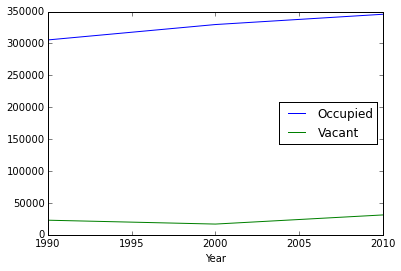

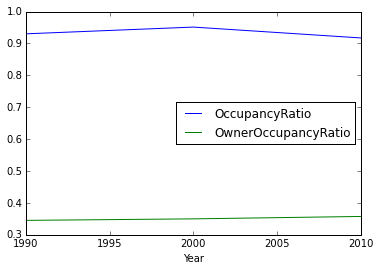

In [218]:
dfDecennial = pd.DataFrame(dResults, index=['2010','2000','1990'], columns=['Year','Occupied','Vacant','OccupancyRatio','OwnerOccupancyRatio'], dtype=float).sort('Year')
print dfDecennial
dfDecennial.plot(x='Year',y=['Occupied','Vacant'])
dfDecennial.plot(x='Year',y=['OccupancyRatio','OwnerOccupancyRatio'])

## Business Dynamics Statistics (1976-2013)

Now, let's get some business data at the state level for the selected geography


In [219]:
import pandas as pd
import numpy as np
years = [1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013]
requestBase = "http://api.census.gov/data/bds/firms"
results = []

print 'The variable names are defined here - http://api.census.gov/data/bds/firms/variables.html'
print

i=0
for year in years:
    params = {
        'key':myKey,
        'get':'emp,net_job_creation', # total employment, net job creation
        'for':'state:'+state,
        'time':year,
        'sic1':'0' # Economy wide
    }

    # Submit the request to the US Census service
    response = requests.get(requestBase,params)
    if i==0:
        print(response.url)
        print
        print "Sample output:"
        print(response.json())
        print
        npArray = np.array(response.json()[0])
    npArray = np.vstack([npArray,response.json()[1]])
    i = i+1

#print results
#print npArray[0]
print "Retrieved Data:"
print npArray[1:]

df = pd.DataFrame(npArray[1:], index=years, columns=npArray[0],dtype=int)

The variable names are defined here - http://api.census.gov/data/bds/firms/variables.html

http://api.census.gov/data/bds/firms?get=emp%2Cnet_job_creation&sic1=0&key=001204b7403884e245c12c35bdcc955c68ca6dda&for=state%3A06&time=1990

Sample output:
[[u'emp', u'net_job_creation', u'sic1', u'time', u'state'], [u'11171471', u'520743', u'0', u'1990', u'06']]

Retrieved Data:
[[u'11171471' u'520743' u'0' u'1990' u'06']
 [u'10922525' u'-246847' u'0' u'1991' u'06']
 [u'10598897' u'-274006' u'0' u'1992' u'06']
 [u'10523744' u'-41151' u'0' u'1993' u'06']
 [u'10460782' u'-43508' u'0' u'1994' u'06']
 [u'10772608' u'319825' u'0' u'1995' u'06']
 [u'10961827' u'178164' u'0' u'1996' u'06']
 [u'11338461' u'364191' u'0' u'1997' u'06']
 [u'11814940' u'524136' u'0' u'1998' u'06']
 [u'12129887' u'285142' u'0' u'1999' u'06']
 [u'12629377' u'529144' u'0' u'2000' u'06']
 [u'13142215' u'343792' u'0' u'2001' u'06']
 [u'12803211' u'-284934' u'0' u'2002' u'06']
 [u'12942795' u'331090' u'0' u'2003' u'06']
 [u'1312

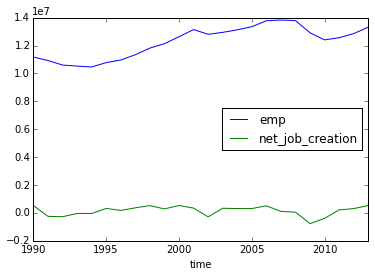

In [220]:
# print df
df = df.astype(int)
df.plot(x='time',y=['emp','net_job_creation'])